# Data visualization and topic modelling on tweets that use the #schoolshooting hashtag

#### Twitter processing code and implementation heavily borrowed, with thanks, from https://github.com/scrapfishies/russian-troll-tweets-nlp

In [1]:
import scattertext as st
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import words, stopwords, wordnet
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation, PCA

from wordcloud import WordCloud, STOPWORDS

from IPython.display import display, HTML

In [2]:
# Dataset provided by Ben, downloaded using twint (which was found and shared by Monica and Emma)
df = pd.read_csv(r'C:\users\j\downloads\schoolshooting_all_20210331.csv')

In [3]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1377365393782673408,1377365393782673408,2021-03-31 14:01:14 PDT,2021-03-31,14:01:14,-700,1047877570740543489,k12ssdb,K-12 School Shooting Database,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1377363373474504707,1377363373474504707,2021-03-31 13:53:13 PDT,2021-03-31,13:53:13,-700,1047877570740543489,k12ssdb,K-12 School Shooting Database,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1377332215785398274,1377332215785398274,2021-03-31 11:49:24 PDT,2021-03-31,11:49:24,-700,821592481,parentsecurity,Parent Security,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1377332210957643777,1377332210957643777,2021-03-31 11:49:23 PDT,2021-03-31,11:49:23,-700,194297917,gregorydevans,Gregory D. Evans,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1377319120774045704,1377319120774045704,2021-03-31 10:57:22 PDT,2021-03-31,10:57:22,-700,109082290,ncsventures,National Cyber Security,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [4]:
'''
Functions for preprocessing tweets from https://github.com/scrapfishies/russian-troll-tweets-nlp
'''

import emoji
import re
import string


def remove_url(text):
    just_text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    return just_text


def remove_hashtags(text):
    clean_text = re.sub(r"\B#\w*[a-zA-Z]+\w*", "", text, flags=re.MULTILINE)
    return clean_text


def get_hashtags(text):
    hashtags = re.findall(r"\B#\w*[a-zA-Z]+\w*", text, flags=re.MULTILINE)
    clean_hashtags = [word.replace("#", "") for word in hashtags]
    return clean_hashtags


def remove_rt_prefix(text):
    clean_text = re.sub(r"RT @\w*[a-zA-Z]+\w*:", "", text, flags=re.MULTILINE)
    return clean_text


def make_alphanumeric(text):
    clean_text = re.sub(r"\w*\d\w*", " ", text)
    return clean_text


def remove_punc(text):
    clean_text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    return clean_text


def demojify(text):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    clean_text = regrex_pattern.sub(r'', text)
    return clean_text


# Cleaning function that will remove emojis, punctuation, RTs, and urls

def clean_tweet(tweet):
    cleaned_tweet = demojify(remove_punc(
        make_alphanumeric(remove_rt_prefix(remove_url(tweet))))).lower()
    cleaned_tweet = re.sub(r" +", " ", cleaned_tweet).strip()
    cleaned_tweet = re.sub(r"([^\x00-\x7F])+", " ", cleaned_tweet)
    return cleaned_tweet

### Creating dataframe of just tweet text

In [5]:
tweets = df[['tweet']].astype(str)

In [6]:
tweets.head()

,tweet
0,Case study in how different state laws range f...
1,A student sent threatening text messages to an...
2,Transcript: Mayor de Blasio Holds Media Availa...
3,Transcript: Mayor de Blasio Holds Media Availa...
4,Kenny Romero helps lead Ewing High bowlers to ...


### Cleaning tweets using function created above

In [7]:
%%time
tweets['clean'] = tweets['tweet'].map(clean_tweet)

Wall time: 6.44 s


In [8]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47282 entries, 0 to 47281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   47282 non-null  object
 1   clean   47282 non-null  object
dtypes: object(2)
memory usage: 738.9+ KB


### Deleting spam tweets 

In [9]:
tweets = tweets[~tweets.clean.str.contains('japan')]

In [10]:
tweets = tweets[~tweets.clean.str.contains('weeb')]

In [80]:
tweets = tweets[~tweets.clean.str.contains('visa')]

In [81]:
tweets.head()

,tweet,clean
0,Case study in how different state laws range f...,case study in how different state laws range f...
1,A student sent threatening text messages to an...,a student sent threatening text messages to an...
2,Transcript: Mayor de Blasio Holds Media Availa...,transcript mayor de blasio holds media availab...
3,Transcript: Mayor de Blasio Holds Media Availa...,transcript mayor de blasio holds media availab...
4,Kenny Romero helps lead Ewing High bowlers to ...,kenny romero helps lead ewing high bowlers to ...


## Create functions to remove stopwords and do a word count

In [82]:
english_words = list(nltk.corpus.words.words())
english_words = [word.lower() for word in english_words]

word_net = list(nltk.corpus.wordnet.words())
word_net = [word.lower() for word in word_net]

many_english_words = set(english_words + word_net)

In [83]:
def word_freq(text, num_words=10, freq_thresh=1000):
    all_words = []
    for tweet in list(text):
        words = tweet.split()
        for word in words:
            if word not in many_english_words:
                all_words.append(word.lower())
    
    top_words = Counter(all_words).most_common(num_words)
    
    results_list = []
    for pair in top_words:
        if pair[1] > freq_thresh:
            results_list.append(pair)
            
    return results_list

### Getting hashtags


In [84]:
hashtag_df = tweets['tweet'].apply(get_hashtags)

hashtags = []
for item in hashtag_df:
    for each in item:
        hashtags.append(each.lower()) #creating list of each hashtag and converting each to lower case

In [85]:
#finding most common hashtags used in tweets with #schoolshooting
word_freq(hashtags, num_words=31, freq_thresh=200)

[('schoolshooting', 45524),
 ('guncontrol', 3470),
 ('guncontrolnow', 2043),
 ('gunviolence', 1606),
 ('guns', 1148),
 ('schoolsafety', 959),
 ('sandyhook', 945),
 ('gunreformnow', 891),
 ('neveragain', 850),
 ('massshooting', 824),
 ('newtown', 817),
 ('floridashooting', 748),
 ('santafe', 700),
 ('parklandshooting', 688),
 ('enoughisenough', 631),
 ('floridaschoolshooting', 614),
 ('gunsense', 587),
 ('schoolshootings', 578),
 ('marchforourlives', 567),
 ('activeshooter', 548),
 ('texasshooting', 542),
 ('2a', 478),
 ('parenting', 478),
 ('schools', 452),
 ('santaclarita', 442),
 ('mentalhealth', 414),
 ('teachers', 396),
 ('students', 389),
 ('santafehighschool', 365),
 ('parklandschoolshooting', 359),
 ('gunreform', 352)]

### Creating wordcloud of hashtags most commonly tweeted with #schoolshooting

In [86]:
hashtag_words = word_freq(hashtags, num_words=30, freq_thresh=200)

hashtag_words.pop(0) #removing 'schoolshooting' hashtag since it was the search term used to create dataset

text = ''
for each in hashtag_words:
    text += each[0] + ' '

In [87]:
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text)

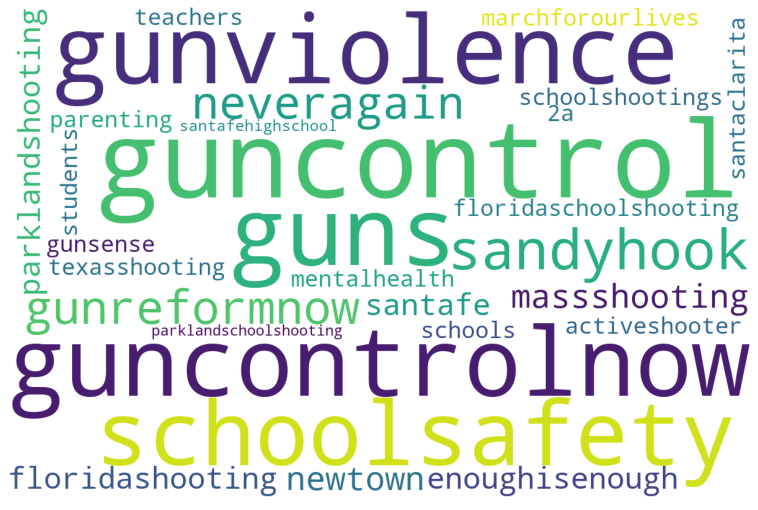

In [88]:
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 4)
  
plt.savefig('hashtag_visualization-4-29.png')

## Word count on ALL terms (not just hashtags) for comparison

### It's interesting to note that while several of the hashtag results also show up in this list, the most common single words used in tweets w/the schoolshooting hashtag refer to the places and victims - "students," "children," "schools," "teachers," etc.

In [89]:
word_freq(tweets['clean'], num_words=20, freq_thresh=500)

[('schoolshooting', 45528),
 ('guncontrol', 3476),
 ('students', 2234),
 ('guns', 2225),
 ('guncontrolnow', 2044),
 ('schools', 1930),
 ('shootings', 1859),
 ('children', 1703),
 ('gunviolence', 1607),
 ('has', 1368),
 ('killed', 1208),
 ('newtown', 1123),
 ('teachers', 1096),
 ('sandyhook', 1011),
 ('realdonaldtrump', 998),
 ('schoolsafety', 959),
 ('victims', 942),
 ('gunreformnow', 891),
 ('neveragain', 850),
 ('massshooting', 824)]

### Filtering tweets to only include those in English

In [90]:
import langdetect as ld

In [91]:
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [92]:
def is_en(txt):
    try:
        return ld.detect(txt)=='en'
    except:
        print("Oops, something went wrong")

tweets = tweets[tweets.clean.apply(is_en)]

In [93]:
tweets.head()

,tweet,clean
0,Case study in how different state laws range f...,case study in how different state laws range f...
1,A student sent threatening text messages to an...,a student sent threatening text messages to an...
2,Transcript: Mayor de Blasio Holds Media Availa...,transcript mayor de blasio holds media availab...
3,Transcript: Mayor de Blasio Holds Media Availa...,transcript mayor de blasio holds media availab...
4,Kenny Romero helps lead Ewing High bowlers to ...,kenny romero helps lead ewing high bowlers to ...


### An add'l cleaning step here could be setting up a hashtag dictionary so that all hashtags are appropriately handled - for example, '#parklandshooting' is bucketed with the other tweets on parkland, '#guncontrolnow' is bucketed with gun control, etc.

In [94]:
print('The date range of the tweets in this dataset is:')
print(df.date.min())
print(df.date.max())

The date range of the tweets in this dataset is:
2009-03-12
2021-03-31


## Setting up LDA model to split tweets by topic, assign topic labels according to most common words w/in each topic group, then put similar topics together for further analysis

In [95]:
proc_tweets = tweets.clean

In [96]:
vectorizer = CountVectorizer(token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True,
                             stop_words='english')

In [97]:
dtm_tf = vectorizer.fit_transform(proc_tweets)
print(dtm_tf.shape)

(45456, 39807)


In [142]:
%%time

lda_model = LatentDirichletAllocation(n_components=12, 
                                      random_state=42, 
                                      n_jobs=-1,
                                      max_iter=200
                                     )


lda_model.fit(dtm_tf)

lda_doc_matrix = lda_model.transform(dtm_tf)

Wall time: 9min 45s


In [143]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [144]:
terms = vectorizer.get_feature_names()

display_topics(lda_model, terms, 30)


Topic  0
schoolshooting, gun, news, parkland, shootings, shooting, new, latest, school, schoolshootings, live, check, schoolsafety, stupid, police, florida, left, tcot, culture, video, kentucky, biden, society, result, coronavirus, violence, safety, guns, episode, control

Topic  1
schoolshooting, school, shooting, story, year, police, old, shot, student, students, shootings, high, schools, threat, schoolsafety, teen, security, gun, man, arrested, shooter, killed, teacher, activeshooter, middle, safety, boy, charged, new, said

Topic  2
schoolshooting, school, support, kids, safe, amp, group, plot, building, teenagers, club, lies, bullies, form, revenge, secrets, truths, discovering, shattering, cindyvine, climax, uncovering, boulder, tweets, schools, topic, solutions, tedx, hour, stunned

Topic  3
schoolshooting, nra, guncontrol, trump, guncontrolnow, gun, guns, realdonaldtrump, parkland, gop, gunviolence, florida, gunsense, gunreformnow, stop, children, america, maga, control, amp, 

In [145]:
lda_doc_matrix.shape

(45456, 12)

## Assigning topics by LDA Results - I used the incident/location first mentioned unless another incident is mentioned more frequently. If more than 2 incidents are mentioned, the topic is assigned as 'general'

## For example, Topic 0 lists 'parkland' and 'florida.' 'kentucky' is also listed, but since the parkland, fl incident has 2 mentions, Topic 0 is assigned to the parkland topic.


In [146]:
topic_cols = ['parkland_1', 'general_1', 'general_2', 'parkland_2', 'columbine_1', 'sandyhook_1', 'general_3', 'general_4', 'parkland_3', 'texas_1', 'sandyhook_2', 'general_5']

In [147]:
lda_df = pd.DataFrame(lda_doc_matrix, columns=topic_cols)

In [148]:
lda_df.head()

,parkland_1,general_1,general_2,parkland_2,columbine_1,sandyhook_1,general_3,general_4,parkland_3,texas_1,sandyhook_2,general_5
0,0.209507,0.469332,0.002874,0.002874,0.295298,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874
1,0.003788,0.753092,0.003788,0.003788,0.078693,0.003788,0.134122,0.003788,0.003788,0.003788,0.003788,0.003788
2,0.010417,0.010417,0.284628,0.010417,0.010417,0.611204,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417
3,0.010417,0.010417,0.284628,0.010417,0.010417,0.611204,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417
4,0.006944,0.006945,0.824128,0.006945,0.006945,0.006945,0.006944,0.106427,0.006945,0.006945,0.006945,0.006945


In [149]:
lda_df['sandyhook'] = lda_df['sandyhook_1'] + lda_df['sandyhook_2']
lda_df['general'] = lda_df['general_1'] + lda_df['general_2']+lda_df['general_3'] + lda_df['general_4'] + lda_df['general_5']
lda_df['parkland'] = lda_df['parkland_1'] + lda_df['parkland_2']+ lda_df['parkland_3']
lda_df['texas'] = lda_df['texas_1']
lda_df['columbine'] = lda_df['columbine_1']

In [150]:
lda_df.head()

,parkland_1,general_1,general_2,parkland_2,columbine_1,sandyhook_1,general_3,general_4,parkland_3,texas_1,sandyhook_2,general_5,sandyhook,general,parkland,texas,columbine
0,0.209507,0.469332,0.002874,0.002874,0.295298,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.002874,0.005747,0.480827,0.215254,0.002874,0.295298
1,0.003788,0.753092,0.003788,0.003788,0.078693,0.003788,0.134122,0.003788,0.003788,0.003788,0.003788,0.003788,0.007576,0.898579,0.011364,0.003788,0.078693
2,0.010417,0.010417,0.284628,0.010417,0.010417,0.611204,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.621621,0.326295,0.031251,0.010417,0.010417
3,0.010417,0.010417,0.284628,0.010417,0.010417,0.611204,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.621621,0.326295,0.031251,0.010417,0.010417
4,0.006944,0.006945,0.824128,0.006945,0.006945,0.006945,0.006944,0.106427,0.006945,0.006945,0.006945,0.006945,0.013889,0.951388,0.020834,0.006945,0.006945


In [151]:
topic_df = lda_df[['sandyhook', 'general', 'parkland', 'texas', 'columbine']]

In [152]:
topic_df['label'] = topic_df.idxmax(axis=1)

In [153]:
topic_df.head()

,sandyhook,general,parkland,texas,columbine,label
0,0.005747,0.480827,0.215254,0.002874,0.295298,general
1,0.007576,0.898579,0.011364,0.003788,0.078693,general
2,0.621621,0.326295,0.031251,0.010417,0.010417,sandyhook
3,0.621621,0.326295,0.031251,0.010417,0.010417,sandyhook
4,0.013889,0.951388,0.020834,0.006945,0.006945,general


## Now that we have assigned topic labels according to the LDA vectors, we can add back in the text, date, and username of each of the tweets

In [154]:
topic_df['tweet'] = tweets.clean
topic_df['date'] = df.date
topic_df['username'] = df.username

In [155]:
topic_df.head()

,sandyhook,general,parkland,texas,columbine,label,tweet,date,username
0,0.005747,0.480827,0.215254,0.002874,0.295298,general,case study in how different state laws range f...,2021-03-31,k12ssdb
1,0.007576,0.898579,0.011364,0.003788,0.078693,general,a student sent threatening text messages to an...,2021-03-31,k12ssdb
2,0.621621,0.326295,0.031251,0.010417,0.010417,sandyhook,transcript mayor de blasio holds media availab...,2021-03-31,parentsecurity
3,0.621621,0.326295,0.031251,0.010417,0.010417,sandyhook,transcript mayor de blasio holds media availab...,2021-03-31,gregorydevans
4,0.013889,0.951388,0.020834,0.006945,0.006945,general,kenny romero helps lead ewing high bowlers to ...,2021-03-31,ncsventures


## Visualizing the topic frequency according to tweet count

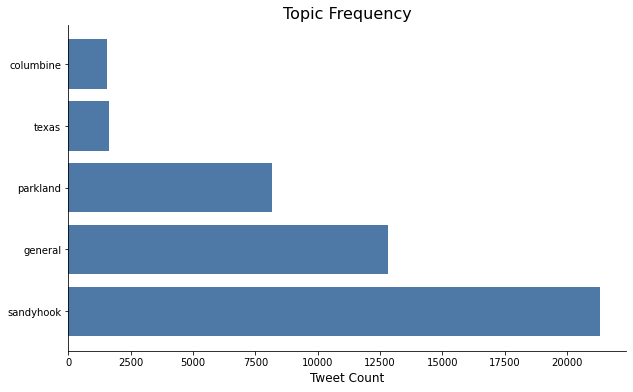

In [156]:
labels = ['sandyhook', 'general', 'parkland', 'texas', 'columbine']

top_freq = list(topic_df['label'].value_counts())

plt.figure(figsize=(10, 6))
plt.barh(labels, top_freq, color='#4e79a7')
plt.xlabel('Tweet Count', fontsize=12)
plt.title("Topic Frequency", fontsize=16)
sns.despine()
plt.savefig(r'../topic_frequency.png');

## Next we will visualize the tweet topics over time

In [157]:
date_freq = topic_df.groupby(['date', 'label']).size().unstack().reset_index()

In [158]:
date_freq.fillna(0, inplace=True)
date_freq['total'] = date_freq.sum(axis=1)

In [159]:
date_freq

label,date,columbine,general,parkland,sandyhook,texas,total
0,2012-12-14,97.0,194.0,49.0,45.0,20.0,405.0
1,2012-12-15,3.0,222.0,49.0,113.0,6.0,393.0
2,2012-12-16,0.0,139.0,22.0,58.0,0.0,219.0
3,2012-12-17,1.0,88.0,20.0,86.0,2.0,197.0
4,2012-12-18,0.0,44.0,6.0,38.0,0.0,88.0
...,...,...,...,...,...,...,...
2301,2021-03-27,4.0,3.0,0.0,0.0,0.0,7.0
2302,2021-03-28,0.0,2.0,0.0,0.0,0.0,2.0
2303,2021-03-29,0.0,10.0,2.0,3.0,0.0,15.0
2304,2021-03-30,0.0,9.0,2.0,1.0,0.0,12.0


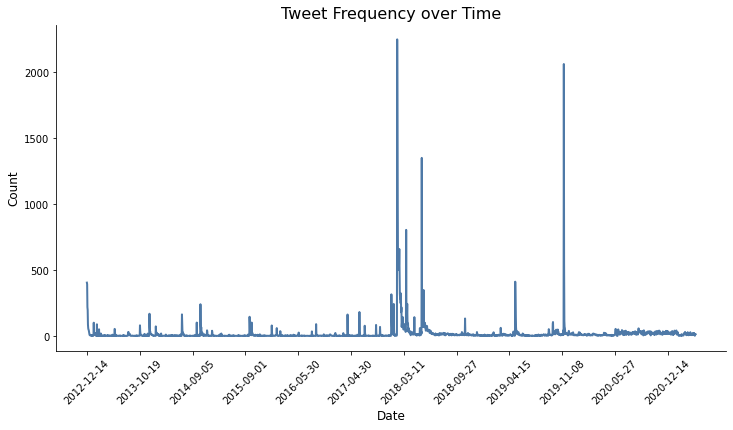

In [160]:
dates = date_freq.date
total_tweets = date_freq.total
x_ticks = list(date_freq.date.unique()[::200])

plt.figure(figsize=(12, 6))
plt.plot(dates, total_tweets, color='#4e79a7', linewidth=2)
plt.title('Tweet Frequency over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(x_ticks, rotation=45)
sns.despine();

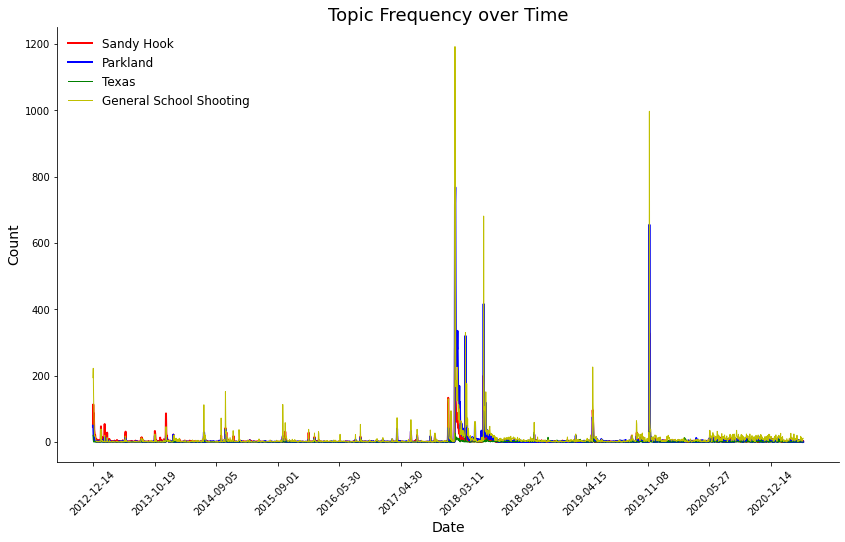

In [161]:
dates_limited = date_freq.date
x_ticks = list(date_freq.date.unique()[::200])

sandyhook = date_freq.sandyhook
parkland = date_freq.parkland
texas = date_freq.texas
general = date_freq.general
#saugushigh = date_freq.saugushigh


plt.figure(figsize=(14, 8))
plt.plot(dates, sandyhook, color='r', linewidth=2, label='Sandy Hook')
plt.plot(dates, parkland, color='b', linewidth=2, label='Parkland')

plt.plot(dates, texas, color='g', linewidth=1, label='Texas')
plt.plot(dates, general, color='y', linewidth=1, label='General School Shooting')
#plt.plot(dates, saugushigh, color='darkred', linewidth=1, label='Saugus High')


plt.title('Topic Frequency over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(x_ticks, rotation=45)
plt.legend(loc='upper left', frameon=False, fontsize=12)
sns.despine()

## There is obviously still plenty to explore - the spikes shown in the previous two visualizations are assumed to correlate with new shootings occurring, but a further exploration of dates, zooming in on the spikes, might show more interesting patterns. 

## Note - the "date" field is not in datetime format and will need to be modified before date operations could be used

## Next I will use a library called Scattertext to see if there are patterns of word usage w/in the labeled tweets. Scattertext uses 2 categories to plot an axis. I will use the categories for Sandy Hook and Parkland for the initial EDA.

In [162]:
scatter_df = topic_df[(topic_df['label'] == 'sandyhook') | 
                      (topic_df['label'] == 'parkland')]

In [163]:
scatter_df.head()

,sandyhook,general,parkland,texas,columbine,label,tweet,date,username
2,0.621621,0.326295,0.031251,0.010417,0.010417,sandyhook,transcript mayor de blasio holds media availab...,2021-03-31,parentsecurity
3,0.621621,0.326295,0.031251,0.010417,0.010417,sandyhook,transcript mayor de blasio holds media availab...,2021-03-31,gregorydevans
17,0.016667,0.041667,0.801776,0.008334,0.131556,parkland,when even books are quarantined reading pro...,2021-03-30,parentsecurity
18,0.016667,0.041667,0.801776,0.008334,0.131556,parkland,when even books are quarantined reading pro...,2021-03-30,gregorydevans
20,0.719053,0.248895,0.019231,0.006410,0.006410,sandyhook,friends family co workers hold prayer vigil fo...,2021-03-30,gregorydevans


In [164]:
scatter_df.shape

(20967, 9)

In [165]:
scatter_df = scatter_df[scatter_df['tweet'] != '']

In [166]:
scatter_df.shape

(20967, 9)

In [167]:
corpus = st.CorpusFromPandas(scatter_df,
                             category_col='label',
                             text_col='tweet',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [168]:
html = st.produce_scattertext_explorer(corpus,
                                       category='sandyhook',
                                       category_name='Sandy Hook',
                                       not_category_name='Parkland',
                                       minimum_term_frequency=100,
                                       pmi_threshold_coefficient=5,
                                       width_in_pixels=1000,
                                      )

In [169]:
file_name = 'sandyhook_parkland_4-30.html'
open(file_name, 'wb').write(html.encode('utf-8'))
HTML(filename=file_name)

## Next steps could include sentiment analysis and a deeper dive into word associations with different categories, but it's encouraging to see the visualizations thus far.